In [1]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

In [3]:
def resize_image(image, target_size):

    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [4]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(os.listdir(folder+label)):
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (250, 250))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [62]:
data, filenames,label, path, distribusi = insertGambar("Dataset/") 
print("Data: ", len(data))
print("Label: ", len(label))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

sampled_infeksi


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


sampled_non_infeksi


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Data:  200
Label:  2
Filenames:  200
Data Distribution:  {'sampled_infeksi': 100, 'sampled_non_infeksi': 100}


In [57]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()  

In [ ]:
def gray_scaling(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

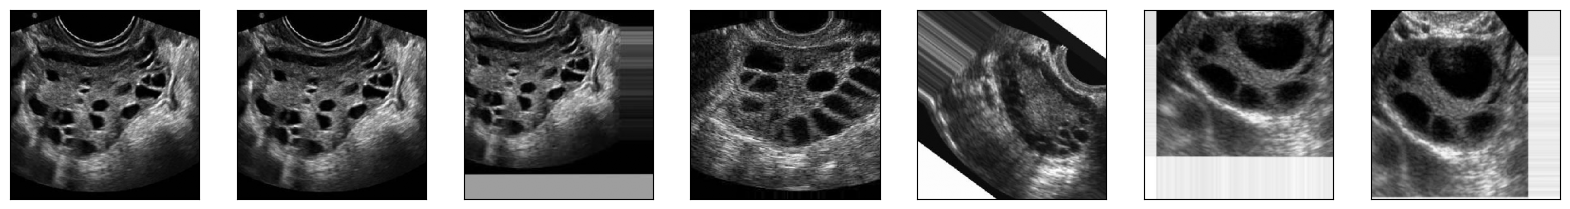

In [63]:
gray_img = gray_scaling(data)

display_sample(gray_img)

In [13]:
def median(img):
    height, width = img.shape
    kernel = np.zeros((3, 3), np.float32) / 9
    hasilMedian = np.zeros((height, width), dtype=np.uint8)
    for i in range(kernel.shape[0]//2, height-kernel.shape[0]//2):
        for j in range(kernel.shape[0]//2, width-kernel.shape[0]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                for l in range(-kernel.shape[0]//2, kernel.shape[0]//2+1):
                    temp.append(img[i+k][j+l])
            temp.sort()
            median = temp[kernel.shape[0]**2//2]
            if kernel.shape[0]**2 % 2 == 0:
                median = (temp[kernel.shape[0]**2//2 - 1] + temp[kernel.shape[0]**2//2]) // 2
            else:
                median = temp[kernel.shape[0]**2//2]
            hasilMedian[i][j] = median

    return hasilMedian

def medianFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = median(img)
        hasil.append(gambar)
    return hasil

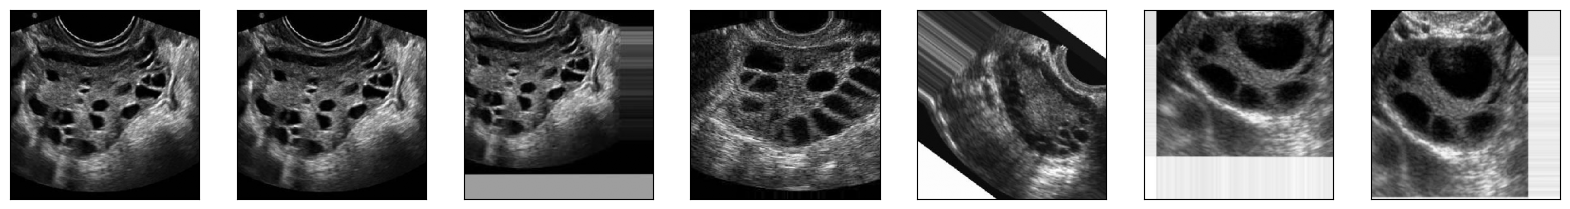

100%|██████████| 200/200 [03:40<00:00,  1.10s/it]


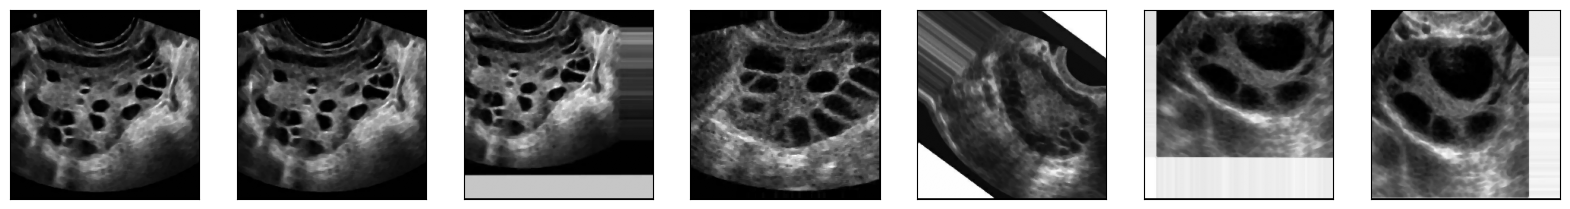

In [ ]:
gray_img = gray_scaling(data)
display_sample(gray_img)

filtered_data = medianFilterData(gray_img)
display_sample(filtered_data)

In [55]:
def ekualisasi_histogram(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    hist = np.zeros(256, dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            hist[image[i, j]] += 1

    cdf = hist.cumsum()
    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = image.size
    cdf_normalized = ((cdf - cdf_min) / (total_pixels - cdf_min)) * 255
    cdf_normalized = cdf_normalized.astype('uint8')

    equalized_image = cdf_normalized[image]
    return equalized_image

def equalize_all_images(image_list):
    equalized_data = []
    for img in tqdm(image_list):
        eq_img = ekualisasi_histogram(img)
        equalized_data.append(eq_img)
    return equalized_data


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


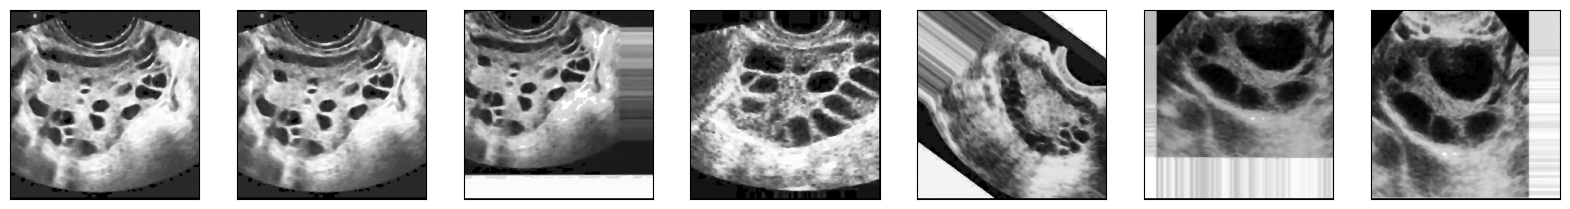

In [58]:
equalized_images = equalize_all_images(filtered_data)
display_sample(equalized_images)

In [51]:
def sobel_filter(image):
    Kx = np.array([[ -1, 0, 1],
                   [ -2, 0, 2],
                   [ -1, 0, 1]])
    Ky = np.array([[  1,  2,  1],
                   [  0,  0,  0],
                   [ -1, -2, -1]])

    height, width = image.shape
    padded_img = np.pad(image, ((1,1),(1,1)), mode='edge')

    sobel_x = np.zeros_like(image, dtype=np.float32)
    sobel_y = np.zeros_like(image, dtype=np.float32)

    for i in range(height):
        for j in range(width):
            region = padded_img[i:i+3, j:j+3]
            gx = np.sum(Kx * region)
            gy = np.sum(Ky * region)
            sobel_x[i, j] = gx
            sobel_y[i, j] = gy

    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = (magnitude / magnitude.max()) * 255
    return magnitude.astype(np.uint8)

def sobelFilterData(image_list):
    hasil = []
    for img in tqdm(image_list, desc="Applying Sobel Filter"):
        hasil.append(sobel_filter(img))
    return hasil


Applying Sobel Filter: 100%|██████████| 200/200 [07:16<00:00,  2.18s/it]


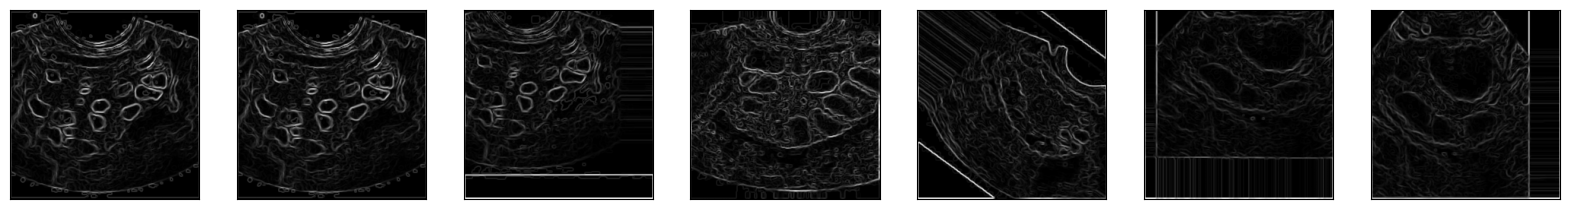

In [59]:
sobel_image = sobelFilterData(equalized_images)
display_sample(sobel_image)

In [74]:
def threshold(gambar):
    ambang = 15
    hasilThreshold = np.where(gambar >= ambang, 128, 255)
    return hasilThreshold

def thresholdFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = threshold(img)
        hasil.append(gambar)
    return hasil

100%|██████████| 200/200 [00:00<00:00, 1010.78it/s]


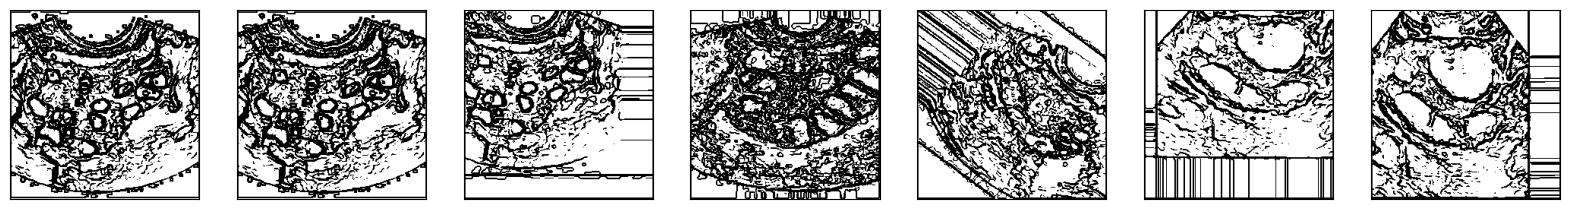

In [75]:
binary_images = thresholdFilterData(sobel_image)
display_sample(binary_images)